In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 70 bytes


In [ ]:
!kaggle datasets download -d muhammetzahitaydn/cigarette-smoker-dataset

Dataset URL: https://www.kaggle.com/datasets/muhammetzahitaydn/cigarette-smoker-dataset
License(s): CC0-1.0


In [ ]:
from zipfile import ZipFile
file_name = "/content/cigarette-smoker-dataset.zip"
with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')

Done


In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import os

In [ ]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "train",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)
val_dataset = dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "valid",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)
class_names = dataset.class_names

Found 7448 files belonging to 2 classes.
Found 784 files belonging to 2 classes.


In [ ]:
from pathlib import Path


data_path = Path('train')
smoking_total = sum(1 for entry in (data_path / 'smoking').iterdir() if entry.is_file())
not_smoking_total = sum(1 for entry in (data_path / 'not_smoking').iterdir() if entry.is_file())

In [ ]:
print(smoking_total,not_smoking_total)

4630 2818


In [ ]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[0 1 0 1 1 1 1 1 1 0 0 1 1 1 1 1 0 0 0 1 1 1 1 1 0 1 1 0 0 1 1 1]


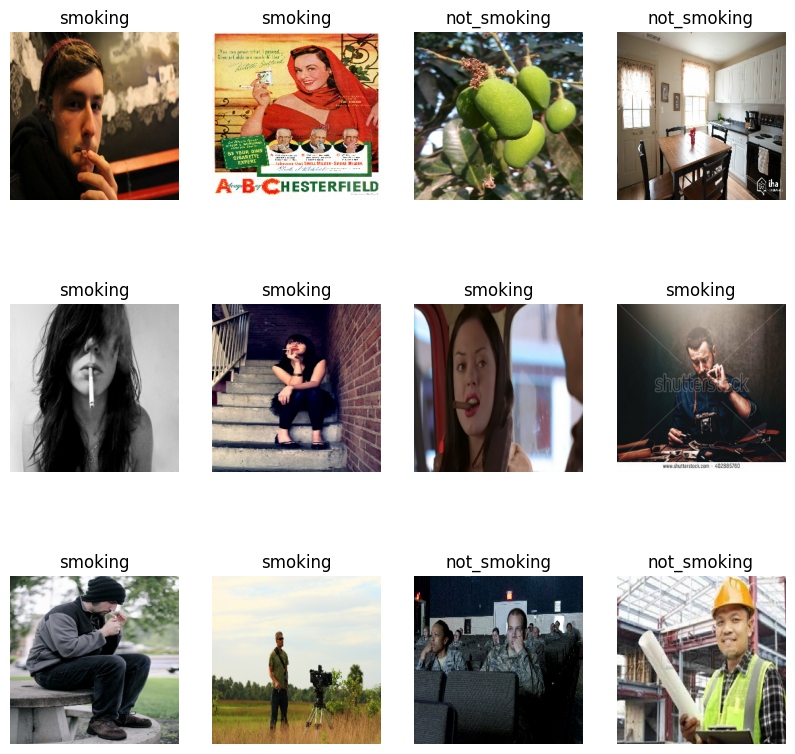

In [ ]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.8, test_split=0.2, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split) == 1
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    train_size = int(train_split * ds_size)
    train_ds = ds.take(train_size)
    test_ds = ds.skip(train_size)
    return train_ds,test_ds

In [ ]:
train_ds, test_ds = get_dataset_partitions_tf(dataset)
val_size = 0.1
val_len=round(len(val_dataset)*val_size)
val_ds = val_dataset.take(val_len)

In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.Rescaling(1./255),
])

In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

In [ ]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 2

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (32, 254, 254, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (32, 127, 127, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (32, 125, 125, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (32, 62, 62, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (32, 60, 60, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (32, 30, 30, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (32, 28, 28, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (32, 14, 14, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (32, 12, 12, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (32, 6, 6, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (32, 4, 4, 64)              │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (32, 2, 2, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (32, 256)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (32, 64)                    │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (32, 2)                     │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 183,682 (717.51 KB)

 Trainable params: 183,682 (717.51 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=test_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 18s 366ms/step - accuracy: 0.5385 - loss: 0.6931 - val_accuracy: 0.5688 - val_loss: 0.6911
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.5295 - loss: 0.6914 - val_accuracy: 0.5312 - val_loss: 0.6864
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.5219 - loss: 0.6828 - val_accuracy: 0.5437 - val_loss: 0.6802
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.5113 - loss: 0.6905 - val_accuracy: 0.5125 - val_loss: 0.6886
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.6077 - loss: 0.6882 - val_accuracy: 0.6187 - val_loss: 0.6581
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.6189 - loss: 0.6606 - val_accuracy: 0.5938 - val_loss: 0.6900
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.6426 - loss: 0.6469 - val_accuracy: 0.6250 - val_loss: 0.6270
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.6060 - loss: 0.6529 - val_accuracy: 0.6500 -

In [ ]:
scores = model.evaluate(val_ds)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7292 - loss: 0.6077


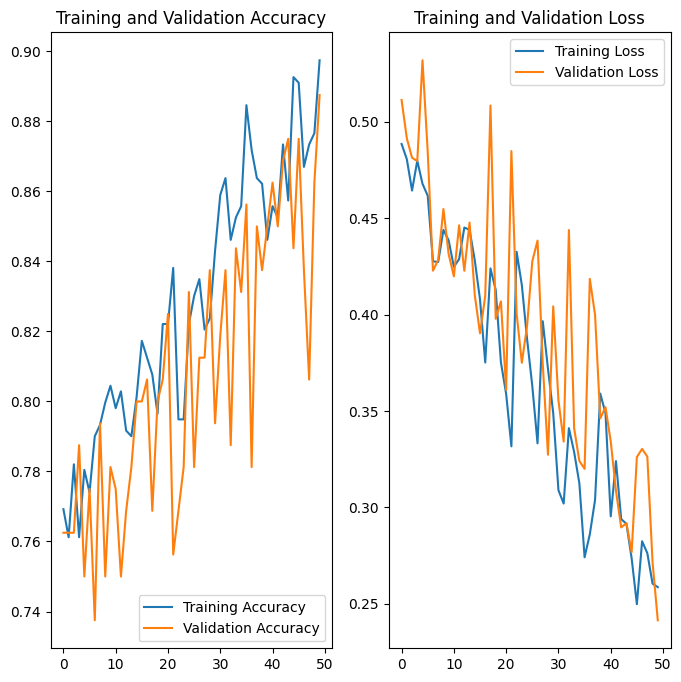

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: smoking
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
predicted label: smoking


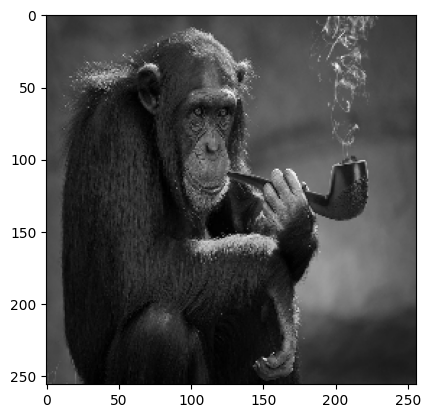

In [ ]:
import numpy as np
for images_batch, labels_batch in val_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


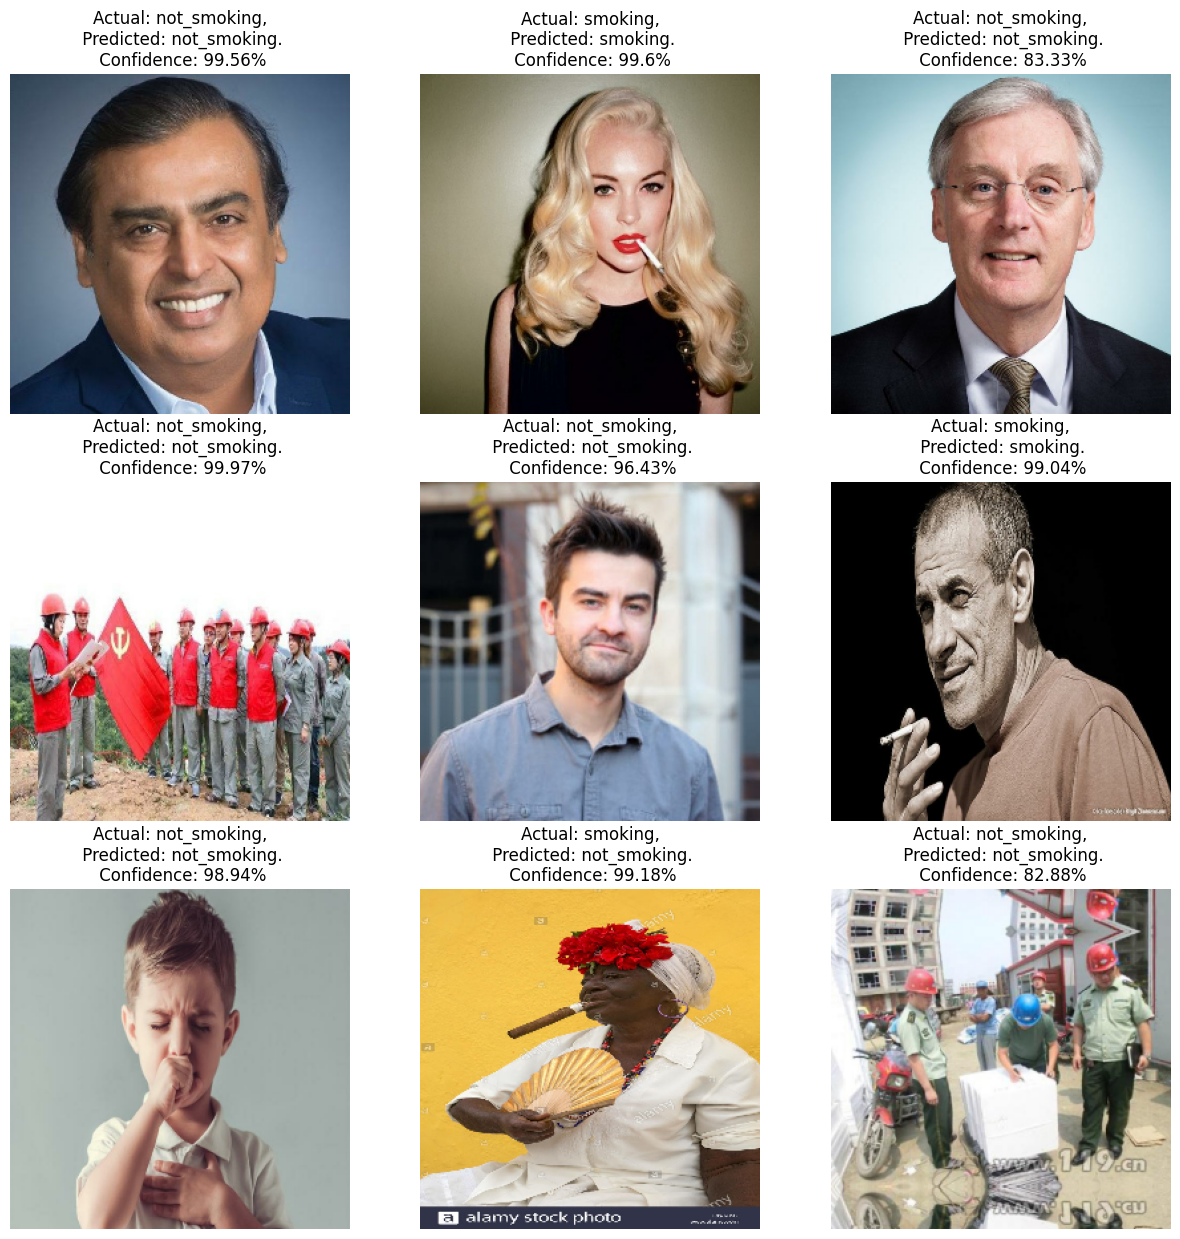

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in val_ds.take(3):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

In [ ]:
import os
import re

model_version = 0  # Initialize to 0

# Iterate through files in the directory
for filename in os.listdir("/content/models"):
    # Use regex to find numeric parts in filenames
    match = re.search(r"\d+", filename)
    if match:
        version = int(match.group())  # Convert matched string to integer
        model_version = max(model_version, version)  # Update model_version

model_version += 1  # Increment to get the next version
model.save(f"/content/models/{model_version}.h5")

FileNotFoundError: [Errno 2] No such file or directory: '/content/models'

In [ ]:
model.save("../smoking.h5")

In [ ]:
# 📦 Required Libraries
import os
import cv2
import numpy as np
from keras.preprocessing import image
from keras.models import load_model
import imageio
from IPython.display import HTML
from base64 import b64encode

# 📁 Create necessary folders
os.makedirs("temp_frames", exist_ok=True)
os.makedirs("outputs", exist_ok=True)

# 🔍 Function to preprocess input for model
def model_preprocess(img):
    # Customize based on your model’s preprocessing needs
    return img / 255.0

# 🔥 Fire Detection Function
def video_fire_detection(input_video_path, output_video_path, image_size=(256, 256), detection_freq=5):
    if not os.path.exists("temp_frames"):
        os.makedirs("temp_frames")

    classes = ['smoking', 'not_smoking']
    nbr_classes = 2

    video_writer = imageio.get_writer(output_video_path, fps=24)

    video = cv2.VideoCapture(input_video_path)
    if not video.isOpened():
        print("Error opening video stream or file")
        return

    frame_nbr = 0
    max_class, max_proba = "unknown", 0

    while video.isOpened():
        not_done, frame = video.read()
        if not_done:
            img_path = f"temp_frames/frame_{frame_nbr}.png"
            cv2.imwrite(img_path, frame)

            if frame_nbr % detection_freq == 0:
                img = image.load_img(img_path, target_size=image_size)
                img = image.img_to_array(img)
                img = np.expand_dims(img, axis=0)
                img = model_preprocess(img)

                probabilities = model.predict(img, batch_size=1, verbose=0)[0]
                result = [(classes[i], float(probabilities[i]) * 100.0) for i in range(nbr_classes)]
                result.sort(reverse=True, key=lambda x: x[1])
                max_class, max_proba = result[0][0], result[0][1]

            # Draw prediction
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            font = cv2.FONT_HERSHEY_SIMPLEX
            text = f"{max_class} : {max_proba:.2f}%"
            textsize = cv2.getTextSize(text, font, 1, 2)[0]
            textX = (img.shape[1] - textsize[0]) // 2
            textY = 30
            cv2.rectangle(img, (textX, textY - 30), (textX + textsize[0], textY), (0, 0, 0), cv2.FILLED)
            cv2.putText(img, text, (textX, textY - 5), font, 1, (255, 255, 255), 2)

            frame_nbr += 1
            video_writer.append_data(img)
        else:
            break

    video_writer.close()
    video.release()


In [ ]:
import ipywidgets as widgets
from IPython.display import display

upload_widget = widgets.FileUpload(accept='.mp4', multiple=False)
display(upload_widget)

FileUpload(value={}, accept='.mp4', description='Upload')

In [ ]:
import cv2
import numpy as np
import os
from keras.models import load_model
from google.colab import widgets
from IPython.display import display, HTML
import base64
import io
from google.colab import files

# Upload video
upload_widget = files.upload()

# Helper function to display video in Colab
def show_video(file_path):
    video = open(file_path, "rb").read()
    video_encoded = base64.b64encode(video).decode("utf-8")
    return HTML(f"""
        <video width=600 controls>
            <source src="data:video/mp4;base64,{video_encoded}" type="video/mp4">
        </video>
    """)

# Fire detection function using your model
def video_fire_detection(input_video_path, output_video_path, image_size=(256, 256), detection_freq=5):
    print("🎥 Opening video...")
    cap = cv2.VideoCapture(input_video_path)
    if not cap.isOpened():
        raise IOError(f"Cannot open video file: {input_video_path}")

    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)

    print(f"🎞️ Input resolution: {width}x{height} @ {fps} fps")

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))

    frame_nbr = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break

        # Process only every 'detection_freq' frames
        if frame_nbr % detection_freq == 0:
            resized_frame = cv2.resize(frame, image_size)
            normalized_frame = resized_frame.astype("float32") / 255.0
            reshaped_frame = np.expand_dims(normalized_frame, axis=0)
            preds = model.predict(reshaped_frame)
            label = 'Smoking' if preds[0][0] > 0.5 else 'No Smoking'
            print(f"📸 Frame {frame_nbr}: Prediction = {label} ({preds[0][0]:.2f})")

            color = (0, 0, 255) if label == 'Smoking' else (0, 255, 0)
            cv2.putText(frame, label, (30, 50), cv2.FONT_HERSHEY_SIMPLEX, 1.5, color, 3)
            cv2.rectangle(frame, (20, 20), (300, 80), color, 2)

        out.write(frame)
        frame_nbr += 1

    cap.release()
    out.release()
    print(f"✅ Output video saved to: {output_video_path}")

# Process the uploaded video
if not upload_widget:
    print("⚠️ No video uploaded.")
else:
    uploaded_filename = list(upload_widget.keys())[0]
    input_video_path = f"./{uploaded_filename}"
    output_video_path = f"./processed_{uploaded_filename}"
    try:
            video_fire_detection(
                input_video_path=input_video_path,
                output_video_path=output_video_path,
                image_size=(256, 256),
                detection_freq=5
            )
            display(show_video(output_video_path))
    except Exception as e:
            print(f"❌ Error: {e}")


Saving 3805926-uhd_4096_2160_25fps.mp4 to 3805926-uhd_4096_2160_25fps.mp4
🎥 Opening video...
🎞️ Input resolution: 4096x2160 @ 25.0 fps
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step
📸 Frame 0: Prediction = Smoking (0.79)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
📸 Frame 5: Prediction = Smoking (0.79)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
📸 Frame 10: Prediction = Smoking (0.79)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
📸 Frame 15: Prediction = Smoking (0.79)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
📸 Frame 20: Prediction = Smoking (0.79)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
📸 Frame 25: Prediction = Smoking (0.79)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
📸 Frame 30: Prediction = Smoking (0.79)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
📸 Frame 35: Prediction = Smoking (0.79)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
📸 Frame 40: Prediction = Smoking (0.79)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
📸 Frame 45: Prediction = Smoking (0.79)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
📸 Frame 50: Prediction = Smoking (0.79)
1/1 ━━━━

In [ ]:
def show_video(video_path):
    mp4 = open(video_path, 'rb').read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
    return HTML(f"""
    <video width=640 controls>
        <source src="{data_url}" type="video/mp4">
    </video>
    """)

show_video(output_path)

In [ ]:
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 MB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.2/322.2 kB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 37.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 5.2 MB/s eta 0:00:00


In [ ]:
import gradio as gr

In [ ]:
def predict_image(img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    predictions = model.predict(img_array)
    return {class_names[i]: predictions[0][i] for i in range(2)}

In [ ]:
image = gr.Image(type='pil')
gr.Interface(fn=predict_image, inputs=image, outputs='label').launch(debug=True)

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://86edd2655e555ba79c.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
Created dataset file at: .gradio/flagged/dataset1.csv
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://86edd2655e555ba79c.gradio.live


In [ ]:
demo = gr.Interface(predict_image,
                    gr.Video(),
                    "playable_video",
                    )

if __name__ == "__main__":
    demo.launch()

ERROR:    Exception in ASGI application
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/uvicorn/protocols/http/h11_impl.py", line 403, in run_asgi
    result = await app(  # type: ignore[func-returns-value]
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/uvicorn/middleware/proxy_headers.py", line 60, in __call__
    return await self.app(scope, receive, send)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/fastapi/applications.py", line 1054, in __call__
    await super().__call__(scope, receive, send)
  File "/usr/local/lib/python3.11/dist-packages/starlette/applications.py", line 112, in __call__
    await self.middleware_stack(scope, receive, send)
  File "/usr/local/lib/python3.11/dist-packages/starlette/middleware/errors.py", line 187, in __call__
    raise exc
  File "/usr/local/lib/python3.11/dist-packages/starlette/middleware/errors.py",

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://255203bc9ea5f4e8ad.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
